# Collection of historical data and 2019-61 forecasts

## 1.Temperature and pH data collection

This section outlines the process for collection and cleaning of data from the eReefs dataset


In [2]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd 
import xarray as xr

import netCDF4
from netCDF4 import Dataset, num2date

import datetime as dt
from dateutil.relativedelta import *

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import seaborn as sns
import cmocean

%matplotlib inline

First we combine and load the relevant datasets 

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

 - eReefs hydrodynamic model GBR4
 - eReefs biogeochemical model GBR4 

In [2]:
#Data url to load from thredds server
# Hydro GBR4
base_url2 = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/monthly-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_monthly-monthly-"

# Biogeo GBR4
base_url = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/monthly-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_monthly-monthly-"



## 1.1. URL compilation

Here we define the date range of the data we want to collect. We can do this by iterating a date range across base URLs. This is possible due to the year-month-day naming structure of the files on the AIMS eReefs THREDDS server.

In [ ]:
# Define starting and ending date of the netcdf file we want to load 
start_date = dt.date(2010, 12, 1)
end_date = dt.date(2019, 4, 30)
delta = relativedelta(months=+1)

# Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
step = True
biofiles = []
while start_date <= end_date:
    
    # Read individual file from the OpeNDAP server
    date = str(start_date.year)+'-'+format(start_date.month, '02')
    start_date += delta    
    biofiles.append(f"{base_url}{date}.nc")
    
bio = xr.open_mfdataset(biofiles)

In [ ]:
# Define starting and ending date of the netcdf file we want to load 
start_date = dt.date(2010, 12, 1)
end_date = dt.date(2019, 4, 30)
delta = relativedelta(months=+1)

# Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
step = True
hydrofiles = []
while start_date <= end_date:
    
    # Read individual file from the OpeNDAP server
    date = str(start_date.year)+'-'+format(start_date.month, '02')
    start_date += delta    
    hydrofiles.append(f"{base_url2}{date}.nc")

hydro = xr.open_mfdataset(hydrofiles)

## 1.2. Variable selection

Now that we have opened the indivudual files and compiled them into two main datasets we can select the necessary variables from the larger dataset for our model

In [ ]:
bio = bio[[ 'PH']]
hydro = hydro[['temp']]

ds_biodepth = bio.sel(k=15)
ds_hydrodepth = hydro.sel(k=15)


## 1.3. Reef Selection

Next we select the reef of interest within the bounds of the GBR

In [ ]:

## Northern Reefs ##
#Davies Reef
# reeflat, reeflon = -18.823797, 147.637696

#Yule Reef
# reeflat, reeflon = -11.949075, 143.985203

# key Reef
# reeflat, reeflon = -12.228707, 143.279144


## Southern Reefs ##
#Heron Reef 
reeflat, reeflon = -23.450571, 151.950123

Now that we have the position (j,i) in the dataset we can extract the variables at this specific location:

In [ ]:
# pH
PHdata= ds_biodepth.PH
PHdata= PHdata.sel(longitude=reeflon, latitude=reeflat, method='nearest').drop_vars({'longitude','latitude','zc'})
PHdata = PHdata.to_dataframe()

# Temperature
temp= ds_hydrodepth.temp
temp= temp.sel(longitude=reeflon, latitude=reeflat, method='nearest').drop_vars({'longitude','latitude','zc'})
temp= temp.to_dataframe()


We now have our two parameters temperature and pH we can combine them into one dataset and save it for further use

In [ ]:
# Combine the two variables
data= xr.merge([temp,PH],)
data["time"] = data["time"].dt.floor("D")
    
data.to_netcdf(f"historical_data/{fname}.nc")

## 1.4. Creating a function for the process outlined above

In [ ]:
# Required packages for function.
import os
import numpy as np
import numpy.ma as ma
import pandas as pd 
import xarray as xr

import netCDF4
from netCDF4 import Dataset, num2date

import datetime as dt
from dateutil.relativedelta import*

In [ ]:
import os
import xarray as xr
import datetime as dt
from dateutil.relativedelta import relativedelta


def temp_PH(reef_lat, reef_lon, fname):

    """
    This funtion collects and cleans data from the eReefs netCDF
    file available on the AIMS OpenDAP server.

    Hydrodynamic model: "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/monthly-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_monthly-monthly-2010-12"
    Biogechemical model: "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/monthly-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_monthly-monthly-2010-12"

    args:

    - reef_lat : latitudinal coordinate of reef location
    - reef_lon : longitudinal coordinate of reef location
    - fname : file name
    """

    # Define the datasets to draw from
    base_url = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/monthly-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_monthly-monthly-"
    base_url2 = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/monthly-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_monthly-monthly-"

    # Biogeochemical
    # Define starting and ending date of the netcdf file we want to load
    start_date = dt.date(2010, 12, 1)
    end_date = dt.date(2019, 4, 30)
    delta = relativedelta(months=+1)

    # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
    step = True
    biofiles = []
    while start_date <= end_date:

        # Read individual file from the OpeNDAP server
        date = str(start_date.year) + "-" + format(start_date.month, "02")
        start_date += delta
        biofiles.append(f"{base_url2}{date}.nc")

    bio = xr.open_mfdataset(biofiles)
    print("Open multiple netcdf bio files from server")

    # Hydrodynamic
    # Define starting and ending date of the netcdf file we want to load
    start_date = dt.date(2010, 12, 1)
    end_date = dt.date(2019, 4, 30)
    delta = relativedelta(months=+1)

    # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
    hydrofiles = []
    while start_date <= end_date:

        # Read individual file from the OpeNDAP server
        date = str(start_date.year) + "-" + format(start_date.month, "02")
        start_date += delta
        hydrofiles.append(f"{base_url}{date}.nc")

    hydro = xr.open_mfdataset(hydrofiles)
    print("Open multiple netcdf hydro files from server")

    # Reef Selection
    # Next we select the reef of interest within the bounds of the GBR

    reeflat, reeflon = reef_lat, reef_lon

    # select depth 1.5m
    ds_biodepth = bio.sel(k=15)
    ds_hydrodepth = hydro.sel(k=15)

    # pH
    PH = ds_biodepth.PH
    PH = PH.sel(longitude=reeflon, latitude=reeflat, method="nearest").drop_vars(
        {"longitude", "latitude", "zc"}
    )
    print("Selecting PH for chosen coordinates")

    # Temperature
    temp = ds_hydrodepth.temp
    temp = temp.sel(longitude=reeflon, latitude=reeflat, method="nearest").drop_vars(
        {"longitude", "latitude", "zc"}
    )
    print("Selecting Temperature for chosen coordinates")

    # Combine the two variables
    data = xr.merge([temp, PH],)
    data["time"] = data["time"].dt.floor("D")
    print("Merging variables into a combined Xarray dataset")

    out_path = "historical_data"
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    ncout = os.path.join(out_path, fname + ".nc")
    data.to_netcdf(ncout)
    print("Saved data in file: ", ncout)

    return data

In [ ]:
import gnet
data = temp_PH(-23.450571, 151.950123, 'Heron_reef')

# 2. Forecasting of temperature and pH parameters

This section utilises the data collected in section 1 to generate forecasted changes of temperature and pH from 2019 to 2061. This will provide the data needed to predict calcification responses to future environmental variables.

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import xarray as xr


from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,7)
%matplotlib inline

Accessing the data collected via the temp_PH() function

In [2]:
ds = xr.open_dataset('historical_data/Heron.nc')


We may want to quickly visualise the data we have collected

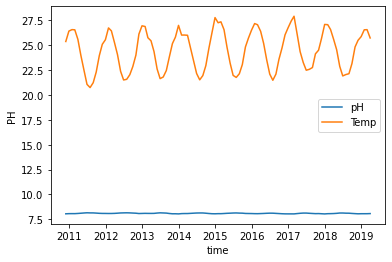

In [3]:
import seaborn as sns
import cmocean


sns.lineplot(x='time' ,y='PH' ,data=ds, label='pH')
sns.lineplot(x='time' ,y='temp' ,data=ds, label="Temp")



## Splitting the data

The ARIMA forecast model is only able to utilise one parameter at a time so we have to divide temperature and pH into their own dataframes


# 2.1 Forecasting

## 2.1.1 pH Forecasting

In [3]:
# Creating a pH dataframe
PHdata = ds.to_dataframe()
PHdata = PHdata[['PH']].resample('MS').mean()
PHdata

,PH
time,
2010-11-01,8.052253
2010-12-01,8.067388
2011-01-01,8.070740
2011-02-01,8.069139
2011-03-01,8.087227
...,...
2018-11-01,8.052619
2018-12-01,8.061267
2019-01-01,8.061467


Summary of PH data
This graphic shows the rolling avg, Trend, Seasonality and Residuals of the dataset


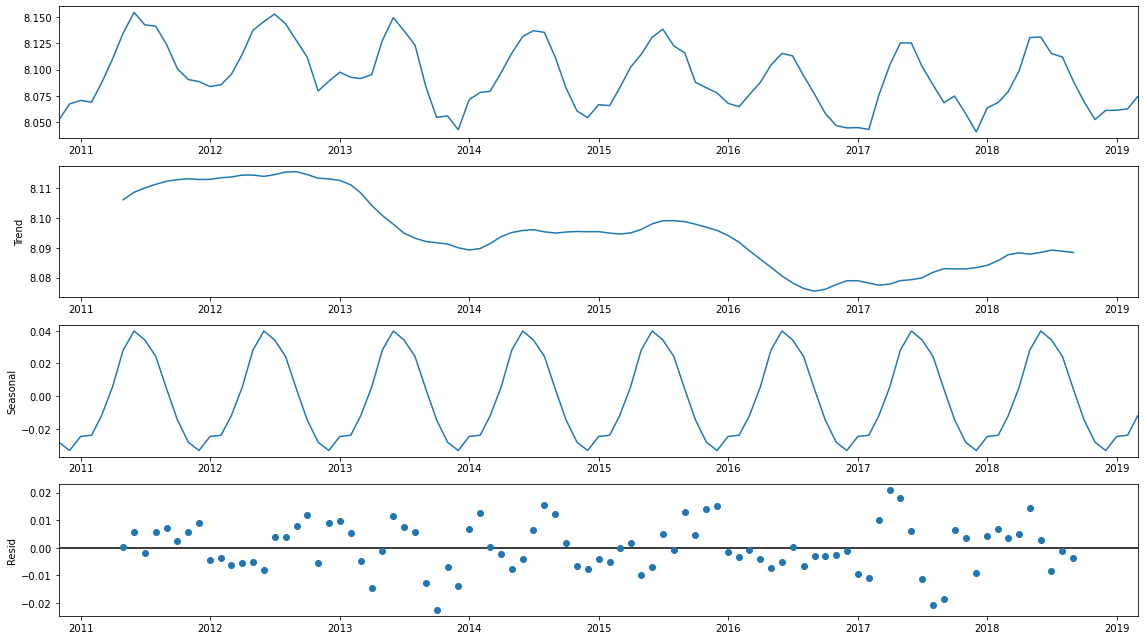

In [4]:
print('Summary of PH data')
print('This graphic shows the rolling avg, Trend, Seasonality and Residuals of the dataset')
decomposition = sm.tsa.seasonal_decompose(PHdata)
plt.rcParams["figure.figsize"] = [16,9]
decomposition.plot()

plt.show()

ARIMA models require the input of parameters p,d & q. The code outlined below generates all possible combinations of theses 3 inputs:

- p: The order of the autoregressive model.
- q: The order of the moving average model.
- d: The number of differences required to make the time series stationary. 

Further models such as SARIMAs also inlcudes the input of seasonal parameters P,D & Q to adress the seasonality of the dataset:

- P: The order of the seasonal autoregressive model.
- Q: The order of the seasonal moving average model.
- D: The number of seasonal differences applied to the time series.

The auto_arima function below allows us to automatically determine the combination of these parameters for our data.
 

## 2.1.2 Iterations

The code below runs a series of combinations of p,d,q & P,D,Q and provides the best model possible. 

The lowest AIC is the better model. (This section provide the best possible model but some manual manipulation is required with complex data)

In [5]:
import itertools
#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(12,13)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline

warnings.filterwarnings("ignore") # specify to ignore warning messages
res = []
params = []
param_seasonals = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(PHdata,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50)
#             print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            res.append(results.aic)
            params.append(param)
            param_seasonals.append(param_seasonal)
        except:
            continue
    

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64724D+00    |proj g|=  2.15797D+01

At iterate    5    f= -2.67758D+00    |proj g|=  6.96165D-02

At iterate   10    f= -2.67761D+00    |proj g|=  3.57276D-01

At iterate   15    f= -2.68127D+00    |proj g|=  1.17044D+01

At iterate   20    f= -2.69857D+00    |proj g|=  2.68598D+00

At iterate   25    f= -2.69877D+00    |proj g|=  6.25372D-03

At iterate   30    f= -2.69882D+00    |proj g|=  2.47336D-01

At iterate   35    f= -2.69885D+00    |proj g|=  2.78895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53765D+00    |proj g|=  1.29933D+00

At iterate    5    f= -2.53913D+00    |proj g|=  4.84972D+00

At iterate   10    f= -2.65372D+00    |proj g|=  2.29109D+01

At iterate   15    f= -2.69186D+00    |proj g|=  3.60740D-01

At iterate   20    f= -2.69719D+00    |proj g|=  1.61987D+00

At iterate   25    f= -2.69760D+00    |proj g|=  1.01220D+00

At iterate   30    f= -2.69781D+00    |proj g|=  7.05854D-01

At iterate   35    f= -2.69905D+00    |proj g|=  9.55963D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64978D+00    |proj g|=  2.26576D+01

At iterate    5    f= -2.68377D+00    |proj g|=  8.30037D-02

At iterate   10    f= -2.68829D+00    |proj g|=  6.23693D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     28      1     0     0   2.260D-02  -2.691D+00
  F =  -2.6905553099169612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f= -2.67336D+00    |proj g|=  5.39362D-01

At iterate   20    f= -2.67530D+00    |proj g|=  3.21796D+00

At iterate   25    f= -2.68835D+00    |proj g|=  2.15334D-01

At iterate   30    f= -2.69568D+00    |proj g|=  7.90959D-02

At iterate   35    f= -2.69658D+00    |proj g|=  1.96239D+00

At iterate   40    f= -2.69735D+00    |proj g|=  2.50523D-01

At iterate   45    f= -2.69779D+00    |proj g|=  1.19533D+00

At iterate   50    f= -2.69827D+00    |proj g|=  2.63499D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   2.635D+00  -2.698D+00
  F =  -2.69827165966

 This problem is unconstrained.



At iterate   10    f= -2.67910D+00    |proj g|=  2.23540D+00

At iterate   15    f= -2.68377D+00    |proj g|=  8.82520D-02

At iterate   20    f= -2.68659D+00    |proj g|=  3.50893D+00

At iterate   25    f= -2.69757D+00    |proj g|=  3.31539D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.69800D+00    |proj g|=  2.73999D-02

At iterate   35    f= -2.69872D+00    |proj g|=  1.34036D+00
  ys=-8.300E-06  -gs= 8.833E-06 BFGS update SKIPPED

At iterate   40    f= -2.69965D+00    |proj g|=  4.38173D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44    118      2     1     0   6.034D-02  -2.700D+00
  F =  -2.6996498757603620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.58423D+00    |proj g|=  1.84424D+01

At iterate    5    f= -2.60546D+00    |proj g|=  1.76849D-01


 This problem is unconstrained.



At iterate   10    f= -2.60727D+00    |proj g|=  6.47295D+00

At iterate   15    f= -2.62006D+00    |proj g|=  1.26414D-01

At iterate   20    f= -2.63802D+00    |proj g|=  1.45171D+01

At iterate   25    f= -2.64418D+00    |proj g|=  1.50888D-01

At iterate   30    f= -2.64944D+00    |proj g|=  6.82982D+00

At iterate   35    f= -2.69012D+00    |proj g|=  1.13497D+01

At iterate   40    f= -2.69743D+00    |proj g|=  1.22475D+00

At iterate   45    f= -2.69896D+00    |proj g|=  9.52696D-01

At iterate   50    f= -2.70259D+00    |proj g|=  2.86685D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74   

 This problem is unconstrained.



At iterate   15    f= -2.72573D+00    |proj g|=  1.26768D+00

At iterate   20    f= -2.72579D+00    |proj g|=  3.54081D-02

At iterate   25    f= -2.72827D+00    |proj g|=  4.29584D-01

At iterate   30    f= -2.72898D+00    |proj g|=  7.21459D-01
  ys=-8.962E-05  -gs= 6.535E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -2.72940D+00    |proj g|=  7.21124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35    113      2     1     0   7.211D-02  -2.729D+00
  F =  -2.7294022960142197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56656D+00    |proj g|=  2.26297D+00

At iterate    5    f= -2.56934D+00    |proj g|=  6.46891D+00

At iterate   10    f= -2.69829D+00    |proj g|=  9.68493D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     72      2     0     0   1.949D-02  -2.733D+00
  F =  -2.7327316107620896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.67708D+00    |proj g|=  2.39664D+01

At iterate    5    f= -2.71343D+00    |proj g|=  8.77389D-02

At iterate   10    f= -2.71364D+00    |proj g|=  1.38457D+00

At iterate   15    f= -2.72111D+00    |proj g|=  1.32216D+00

At iter

 This problem is unconstrained.



At iterate    5    f= -2.62557D+00    |proj g|=  1.29520D+00

At iterate   10    f= -2.67791D+00    |proj g|=  1.88242D+01

At iterate   15    f= -2.70605D+00    |proj g|=  2.24462D-01

At iterate   20    f= -2.72846D+00    |proj g|=  1.17842D+00

At iterate   25    f= -2.72910D+00    |proj g|=  7.59157D-01

At iterate   30    f= -2.72958D+00    |proj g|=  6.80189D-02

At iterate   35    f= -2.72963D+00    |proj g|=  6.18269D-01

At iterate   40    f= -2.73010D+00    |proj g|=  7.85455D-01

At iterate   45    f= -2.73051D+00    |proj g|=  1.05105D-01

At iterate   50    f= -2.73087D+00    |proj g|=  1.89723D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -2.71475D+00    |proj g|=  2.21855D+00

At iterate   15    f= -2.72179D+00    |proj g|=  1.32119D+00

At iterate   20    f= -2.72238D+00    |proj g|=  5.69727D-01

At iterate   25    f= -2.72773D+00    |proj g|=  1.91918D+00

At iterate   30    f= -2.72788D+00    |proj g|=  7.51916D-02

At iterate   35    f= -2.72906D+00    |proj g|=  2.73494D-01

At iterate   40    f= -2.72959D+00    |proj g|=  2.85660D-01

At iterate   45    f= -2.72974D+00    |proj g|=  5.01879D-01

At iterate   50    f= -2.72984D+00    |proj g|=  6.23995D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72   

 This problem is unconstrained.



At iterate   10    f= -2.65958D+00    |proj g|=  7.58154D+00

At iterate   15    f= -2.67335D+00    |proj g|=  3.53832D-01

At iterate   20    f= -2.67709D+00    |proj g|=  2.55825D-01

At iterate   25    f= -2.69348D+00    |proj g|=  4.21047D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     51      1     0     0   6.215D-02  -2.694D+00
  F =  -2.6935155455602531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64991D+00    |proj g|=  2.18646D+01

At iterate    5    f= -2.68114D+00    |proj g|=  7.23735D-02

At iterate   10    f= -2.68208D+00    |proj g|=  1.69026D+00

At iterate   15    f= -2.71462D+00    |proj g|=  8.80068D+00

At iterate   20    f= -2.72375D+00    |proj g|=  3.27587D-01

At iterate   25    f= -2.72402D+00    |proj g|=  3.69518D-01

At iterate   30    f= -2.72472D+00    |proj g|=  1.83543D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     94      2     0     0   8.411D-02  -2.725D+00
  F =  -2.7247263955865653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54077D+00    |proj g|=  1.63747D+00

At iterate    5    f= -2.54183D+00    |proj g|=  3.64276D+00

At iterate   10    f= -2.62784D+00    |proj g|=  3.02606D+01

At iterate   15    f= -2.70262D+00    |proj g|=  6.39440D+00

At iter

 This problem is unconstrained.



At iterate   20    f= -2.69540D+00    |proj g|=  2.19728D-02

At iterate   25    f= -2.69697D+00    |proj g|=  1.76202D-01

At iterate   30    f= -2.70383D+00    |proj g|=  9.96770D+00

At iterate   35    f= -2.71843D+00    |proj g|=  6.98098D-01

At iterate   40    f= -2.72891D+00    |proj g|=  8.07550D-02

At iterate   45    f= -2.72943D+00    |proj g|=  2.13835D+00

At iterate   50    f= -2.73034D+00    |proj g|=  8.59503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   8.595D-02  -2.730D+00
  F =  -2.7303444655419158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f= -2.60717D+00    |proj g|=  1.11193D+00

At iterate   10    f= -2.62405D+00    |proj g|=  1.47151D+01

At iterate   15    f= -2.67550D+00    |proj g|=  2.19609D-01

At iterate   20    f= -2.68430D+00    |proj g|=  1.21982D+00

At iterate   25    f= -2.69189D+00    |proj g|=  1.02373D-01

At iterate   30    f= -2.69672D+00    |proj g|=  3.92240D+00

At iterate   35    f= -2.70382D+00    |proj g|=  2.67842D+00

At iterate   40    f= -2.70586D+00    |proj g|=  2.61211D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41    120      2     0     0   2.612D-02  -2.706D+00
  F =  -2.7058581501914110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64841D+00    |proj g|=  2.28051D+01

At iterate    5    f= -2.68284D+00    |proj g|=  8.64242D-02

At iterate   10    f= -2.68314D+00    |proj g|=  2.60036D+00

At iterate   15    f= -2.68851D+00    |proj g|=  1.74837D+00

At iterate   20    f= -2.68863D+00    |proj g|=  2.53746D-01

At iterate   25    f= -2.69024D+00    |proj g|=  3.30553D+00

At iterate   30    f= -2.70419D+00    |proj g|=  7.65487D+00

At iterate   35    f= -2.71781D+00    |proj g|=  2.68039D-01

At iterate   40    f= -2.71784D+00    |proj g|=  9.35765D-01

At iterate   45    f= -2.72213D+00    |proj g|=  1.44810D+00

At iterate   50    f= -2.72343D+00    |proj g|=  1.06589D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.61043D+00    |proj g|=  1.32809D-01

At iterate   10    f= -2.61514D+00    |proj g|=  8.66126D+00

At iterate   15    f= -2.62641D+00    |proj g|=  1.72763D-01

At iterate   20    f= -2.64155D+00    |proj g|=  2.81663D+00

At iterate   25    f= -2.65006D+00    |proj g|=  8.22065D-01

At iterate   30    f= -2.69719D+00    |proj g|=  2.06449D+00

At iterate   35    f= -2.70761D+00    |proj g|=  5.77229D-02
  ys=-2.401E-04  -gs= 9.446E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.70776D+00    |proj g|=  2.26216D-01

At iterate   45    f= -2.70784D+00    |proj g|=  2.01935D+00

At iterate   50    f= -2.71434D+00    |proj g|=  3.57331D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     93      2     1     0   3.573D-01  -2.714D+00
  F =  -2.7143410952070113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66187D+00    |proj g|=  1.90386D+01

At iterate    5    f= -2.68216D+00    |proj g|=  1.01081D-01

At iterate   10    f= -2.68293D+00    |proj g|=  3.22353D+00

At iterate   15    f= -2.70208D+00    |proj g|=  7.21805D-01

At iterate   20    f= -2.70210D+00    |proj g|=  3.84401D-01

At iterate   25    f= -2.70700D+00    |proj g|=  7.44205D+00

At iterate   30    f= -2.71169D+00    |proj g|=  9.64816D-01

At iterate   35    f= -2.71332D+00    |proj g|=  6.51612D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f= -2.66612D+00    |proj g|=  2.30719D+01

At iterate   15    f= -2.70180D+00    |proj g|=  8.58429D-01

At iterate   20    f= -2.70185D+00    |proj g|=  1.69732D-01

At iterate   25    f= -2.70221D+00    |proj g|=  2.42531D+00

At iterate   30    f= -2.70790D+00    |proj g|=  7.63643D-02

At iterate   35    f= -2.71002D+00    |proj g|=  4.17010D+00

At iterate   40    f= -2.71263D+00    |proj g|=  1.28267D+00

At iterate   45    f= -2.71345D+00    |proj g|=  1.08511D+00

At iterate   50    f= -2.72049D+00    |proj g|=  3.02262D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66678D+00    |proj g|=  2.05774D+01

At iterate    5    f= -2.69094D+00    |proj g|=  8.55187D-02

At iterate   10    f= -2.70091D+00    |proj g|=  8.79743D+00

At iterate   15    f= -2.70780D+00    |proj g|=  7.44728D-01

At iterate   20    f= -2.71062D+00    |proj g|=  4.48811D+00

At iterate   25    f= -2.71259D+00    |proj g|=  1.89193D-02

At iterate   30    f= -2.71533D+00    |proj g|=  9.40481D-01

At iterate   35    f= -2.71717D+00    |proj g|=  4.68303D-02

At iterate   40    f= -2.71723D+00    |proj g|=  1.44383D-01

At iterate   45    f= -2.71732D+00    |proj g|=  6.22332D-01

At iterate   50    f= -2.71765D+00    |proj g|=  5.64445D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -2.60204D+00    |proj g|=  1.91695D+00

At iterate   10    f= -2.68707D+00    |proj g|=  1.96112D+00

At iterate   15    f= -2.68742D+00    |proj g|=  1.65041D-01

At iterate   20    f= -2.69147D+00    |proj g|=  1.77033D+00

At iterate   25    f= -2.70426D+00    |proj g|=  3.31951D-01

At iterate   30    f= -2.71191D+00    |proj g|=  1.06412D+00

At iterate   35    f= -2.71198D+00    |proj g|=  1.64675D-01

At iterate   40    f= -2.71213D+00    |proj g|=  4.54105D-01

At iterate   45    f= -2.71312D+00    |proj g|=  1.14198D+00

At iterate   50    f= -2.71494D+00    |proj g|=  3.13698D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.68577D+00    |proj g|=  7.44668D-02

At iterate   10    f= -2.68587D+00    |proj g|=  1.88300D+00
  ys=-4.843E-08  -gs= 4.487E-08 BFGS update SKIPPED

At iterate   15    f= -2.69191D+00    |proj g|=  3.38259D-01

At iterate   20    f= -2.69217D+00    |proj g|=  2.95389D-01

At iterate   25    f= -2.70107D+00    |proj g|=  5.54555D-01

At iterate   30    f= -2.70617D+00    |proj g|=  1.25800D+00

At iterate   35    f= -2.70997D+00    |proj g|=  2.66459D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.71000D+00    |proj g|=  4.69825D-02

At iterate   45    f= -2.71034D+00    |proj g|=  1.21038D+00

At iterate   50    f= -2.71301D+00    |proj g|=  5.36104D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    110      2     1     0   5.361D-01  -2.713D+00
  F =  -2.7130113527617734     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.60470D+00    |proj g|=  1.66866D+01


 This problem is unconstrained.



At iterate    5    f= -2.61985D+00    |proj g|=  1.63840D-01

At iterate   10    f= -2.62136D+00    |proj g|=  8.15637D+00

At iterate   15    f= -2.66241D+00    |proj g|=  2.13139D+00

At iterate   20    f= -2.66257D+00    |proj g|=  1.08310D-01

At iterate   25    f= -2.67010D+00    |proj g|=  2.59785D+00

At iterate   30    f= -2.67738D+00    |proj g|=  3.98970D-01

At iterate   35    f= -2.68511D+00    |proj g|=  2.91194D+00

At iterate   40    f= -2.68905D+00    |proj g|=  1.54461D-01

At iterate   45    f= -2.71480D+00    |proj g|=  1.33497D+00

At iterate   50    f= -2.72481D+00    |proj g|=  7.12700D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.69346D+00    |proj g|=  6.29325D-02

At iterate   10    f= -2.69365D+00    |proj g|=  3.65625D+00

At iterate   15    f= -2.69709D+00    |proj g|=  3.12189D+00

At iterate   20    f= -2.70763D+00    |proj g|=  7.35530D-01

At iterate   25    f= -2.71808D+00    |proj g|=  2.14190D-02

At iterate   30    f= -2.71820D+00    |proj g|=  1.28214D-01

At iterate   35    f= -2.71829D+00    |proj g|=  6.15634D-01

At iterate   40    f= -2.71836D+00    |proj g|=  5.57729D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     79      1     0     0   5.951D-01  -2.718D+00
  F =  -2.71842940355


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -2.70426D+00    |proj g|=  5.59404D-01

At iterate   20    f= -2.70516D+00    |proj g|=  2.87199D+00

At iterate   25    f= -2.71212D+00    |proj g|=  1.91135D-01

At iterate   30    f= -2.71244D+00    |proj g|=  6.60445D-01

At iterate   35    f= -2.71436D+00    |proj g|=  2.79948D+00

At iterate   40    f= -2.71769D+00    |proj g|=  4.08797D+00

At iterate   45    f= -2.71842D+00    |proj g|=  1.61385D+00

At iterate   50    f= -2.71864D+00    |proj g|=  7.14953D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74      1     0     0   7.150D-01  -2.719D+00
  F =  -2.71864381404

 This problem is unconstrained.



At iterate   10    f= -2.70020D+00    |proj g|=  2.38227D+00

At iterate   15    f= -2.70586D+00    |proj g|=  3.63077D-01

At iterate   20    f= -2.70627D+00    |proj g|=  9.46474D-01

At iterate   25    f= -2.70774D+00    |proj g|=  4.42832D-01

At iterate   30    f= -2.70778D+00    |proj g|=  3.49388D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     45      1     0     0   1.107D-01  -2.708D+00
  F =  -2.7077762527958797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f= -2.61599D+00    |proj g|=  1.16886D+00

At iterate   10    f= -2.63108D+00    |proj g|=  1.50820D+01

At iterate   15    f= -2.68661D+00    |proj g|=  1.78850D-01

At iterate   20    f= -2.69180D+00    |proj g|=  1.08939D+01

At iterate   25    f= -2.69869D+00    |proj g|=  2.70384D-01

At iterate   30    f= -2.70196D+00    |proj g|=  2.69058D+00

At iterate   35    f= -2.70951D+00    |proj g|=  6.17053D+00

At iterate   40    f= -2.71224D+00    |proj g|=  2.77311D-01

At iterate   45    f= -2.71302D+00    |proj g|=  6.98683D-01

At iterate   50    f= -2.71311D+00    |proj g|=  4.57754D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66405D+00    |proj g|=  2.28231D+01

At iterate    5    f= -2.69681D+00    |proj g|=  6.81816D-02

At iterate   10    f= -2.69704D+00    |proj g|=  2.43285D+00

At iterate   15    f= -2.70136D+00    |proj g|=  1.37068D+00

At iterate   20    f= -2.70154D+00    |proj g|=  1.04446D+00

At iterate   25    f= -2.70405D+00    |proj g|=  5.02886D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.70531D+00    |proj g|=  2.17132D-01

At iterate   35    f= -2.70564D+00    |proj g|=  1.27518D+00

At iterate   40    f= -2.70842D+00    |proj g|=  2.15423D-02

At iterate   45    f= -2.70965D+00    |proj g|=  2.81011D-02

At iterate   50    f= -2.71015D+00    |proj g|=  7.40152D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     91      2     0     0   7.402D-01  -2.710D+00
  F =  -2.7101501569415238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate    5    f= -2.63038D+00    |proj g|=  1.36957D-01

At iterate   10    f= -2.63281D+00    |proj g|=  8.09045D+00

At iterate   15    f= -2.64621D+00    |proj g|=  1.60827D+00

At iterate   20    f= -2.66305D+00    |proj g|=  1.69284D+00

At iterate   25    f= -2.66342D+00    |proj g|=  3.10838D-01

At iterate   30    f= -2.66421D+00    |proj g|=  3.80389D-01

At iterate   35    f= -2.66821D+00    |proj g|=  1.42152D+00

At iterate   40    f= -2.67041D+00    |proj g|=  8.13635D-02

At iterate   45    f= -2.69363D+00    |proj g|=  9.46557D+00

At iterate   50    f= -2.71301D+00    |proj g|=  1.07755D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48485D+00    |proj g|=  1.07427D+01

At iterate    5    f= -2.49051D+00    |proj g|=  3.67490D+00

At iterate   10    f= -2.57602D+00    |proj g|=  3.50830D+01

At iterate   15    f= -2.64266D+00    |proj g|=  2.43527D+00

At iterate   20    f= -2.68761D+00    |proj g|=  1.30443D+01

At iterate   25    f= -2.72617D+00    |proj g|=  3.02518D+00

At iterate   30    f= -2.72636D+00    |proj g|=  6.14164D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -2.51213D+00    |proj g|=  2.43299D+01

At iterate   15    f= -2.60542D+00    |proj g|=  2.84967D-01

At iterate   20    f= -2.63714D+00    |proj g|=  1.01269D+01

At iterate   25    f= -2.71702D+00    |proj g|=  2.10198D+00

At iterate   30    f= -2.71911D+00    |proj g|=  9.37661D-01

At iterate   35    f= -2.72812D+00    |proj g|=  1.94940D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     63      1     0     0   4.900D-01  -2.729D+00
  F =  -2.7286185814627699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -2.63423D+00    |proj g|=  9.98855D+00

At iterate   15    f= -2.64315D+00    |proj g|=  9.47731D-01

At iterate   20    f= -2.71541D+00    |proj g|=  6.71638D-01

At iterate   25    f= -2.71811D+00    |proj g|=  5.77333D-01

At iterate   30    f= -2.71826D+00    |proj g|=  2.42829D-01

At iterate   35    f= -2.72090D+00    |proj g|=  1.84514D+00

At iterate   40    f= -2.72240D+00    |proj g|=  1.98110D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44    103      2     0     0   2.115D-02  -2.722D+00
  F =  -2.7224126946521907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.39755D+00    |proj g|=  2.37359D+01

At iterate    5    f= -2.41902D+00    |proj g|=  1.97771D+00


 This problem is unconstrained.



At iterate   10    f= -2.57329D+00    |proj g|=  3.54341D+01

At iterate   15    f= -2.65092D+00    |proj g|=  5.10634D+00

At iterate   20    f= -2.71669D+00    |proj g|=  4.55898D+00

At iterate   25    f= -2.72538D+00    |proj g|=  2.47160D+00

At iterate   30    f= -2.72604D+00    |proj g|=  2.40756D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -2.72609D+00    |proj g|=  4.48110D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     76      1     0     0   4.481D-01  -2.726D+00
  F =  -2.7260875104578037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48692D+00    |proj g|=  9.20909D+00

At iterate    5    f= -2.49359D+00    |proj g|=  7.16895D+00

At iterate   10    f= -2.63040D+00    |proj g|=  9.94186D+00

At iter

 This problem is unconstrained.



At iterate   10    f= -2.46798D+00    |proj g|=  3.31359D+01

At iterate   15    f= -2.56438D+00    |proj g|=  1.18096D+00

At iterate   20    f= -2.57716D+00    |proj g|=  1.34246D+01

At iterate   25    f= -2.63436D+00    |proj g|=  2.58548D+00

At iterate   30    f= -2.63730D+00    |proj g|=  1.24517D+00

At iterate   35    f= -2.70846D+00    |proj g|=  1.85809D-01

At iterate   40    f= -2.72170D+00    |proj g|=  1.40203D+00

At iterate   45    f= -2.72218D+00    |proj g|=  2.37025D+00

At iterate   50    f= -2.72291D+00    |proj g|=  5.17882D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     72   

In [6]:
res = np.array(res)
k = res.argmin()
print('Minimum AIC',res.argmin())
print('ARIMA{}x{}12 - AIC:{}'.format(params[k], param_seasonals[k], res[k]))


Minimum AIC 6
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:-543.3392637948724


### The outcome of this function is then applied to the SARIMAx model 

In [7]:
PH_mod = sm.tsa.statespace.SARIMAX(PHdata,
                                order= params[k],
                                seasonal_order= param_seasonals[k],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = PH_mod.fit()

print(results.summary().tables[1])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22183D+00    |proj g|=  1.72107D+01

At iterate    5    f= -2.24344D+00    |proj g|=  1.50795D-01

At iterate   10    f= -2.24469D+00    |proj g|=  4.61665D+00

At iterate   15    f= -2.27255D+00    |proj g|=  4.24967D+00


 This problem is unconstrained.



At iterate   20    f= -2.27335D+00    |proj g|=  6.22728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     50      1     0     0   6.227D-02  -2.273D+00
  F =  -2.2733513051884815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0756      0.106     -0.716      0.474      -0.283       0.131
ma.L2         -0.3787      0.108     -3.500      0.000      -0.591      -0.167
ma.S.L12      -0.9861      4.041     -0.244  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Below is a graphical diagnostic model assessing its validity

PH Graphical diagnostic


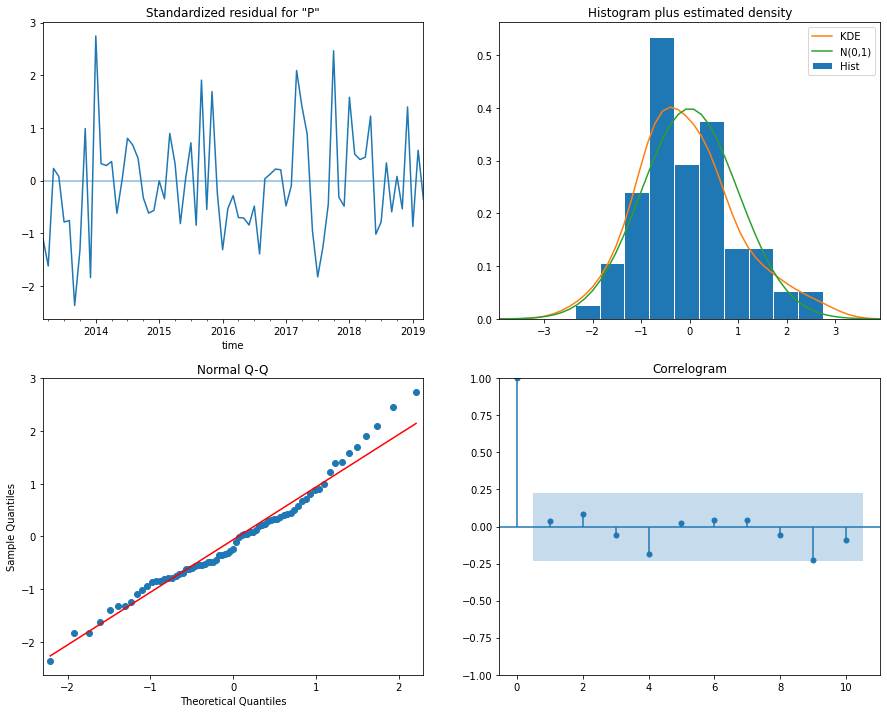

In [8]:
print('PH Graphical diagnostic')
results.plot_diagnostics(figsize=(15, 12))
plt.show()


With a model now generated we can run a backcast in order to assess the accuracy of the model with historical data.

There are two kinds of models:
- Non-dynamic: the forecasts are based on historical data only
- Dynamic: the forecasts are affected by the cumulative forecasted periods


In [11]:
pred_PH = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred_PH.conf_int()


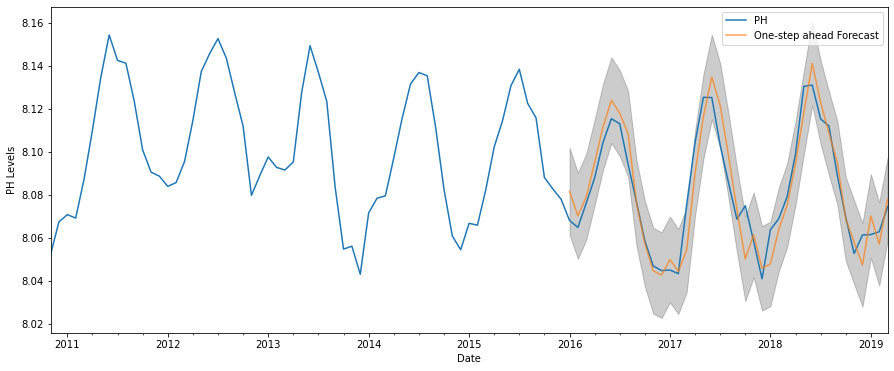

In [12]:
ax = PHdata.plot(label='observed',figsize=(15, 6))
pred_PH.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
    
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('PH Levels')
plt.legend()

plt.show()


In [13]:
PH_forecasted = pred_PH.predicted_mean.values
PH_truth = PHdata['2016-01-01':].values

# Compute the mean square error
mse = ((PH_forecasted - PH_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))


The Mean Squared Error of our forecasts is 0.001505


In [9]:
pred_dynamic_PH = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic_PH.conf_int()



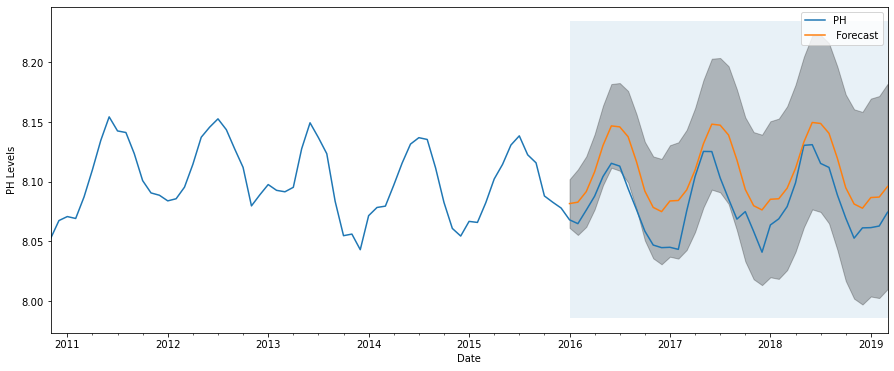

In [11]:
ax = PHdata.plot(label='observed', figsize=(15, 6))
pred_dynamic_PH.predicted_mean.plot(label=' Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), PHdata.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('PH Levels')

plt.legend()
plt.show()



In [16]:
# Extract the predicted and true values of our time series
PH_forecasted = pred_dynamic_PH.predicted_mean
PH_truth = PHdata.PH

# Compute the mean square error
mse = ((PH_forecasted - PH_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))



The Mean Squared Error of our forecasts is 0.000812


We can see that the dynamic is more accurate than the non-dynamic model and therefore be used in the final long-forecast.

This forecast will be 502 steps into the future starting at 01-03-2019, placing the the final date as 01-01-2061

In [12]:
# Get forecast 502 steps ahead in future
pred_PH = results.get_forecast(steps=505)

# Get confidence intervals of forecasts
pred_ci = pred_PH.conf_int()



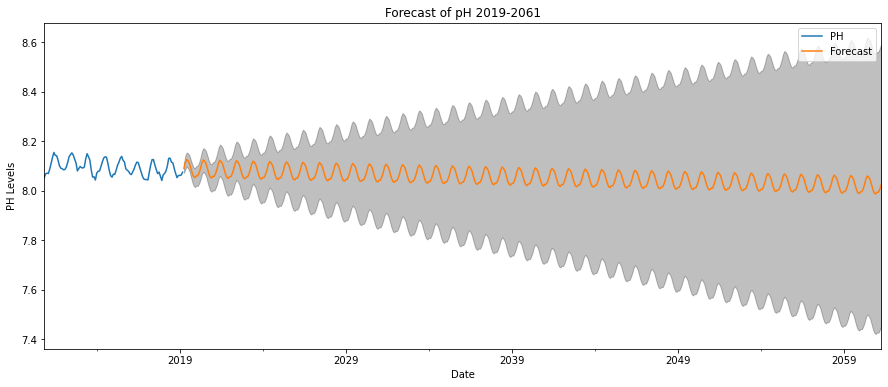

In [13]:
ax = PHdata.plot(label='observed', figsize=(15, 6))
pred_PH.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Forecast of pH 2019-2061')
ax.set_xlabel('Date')
ax.set_ylabel('PH Levels')

plt.legend()
plt.show()


## 3. We now repeat this process for the temperature


In [17]:
tempdata = ds.to_dataframe()
tempdata= tempdata[['temp']].resample('MS').mean()
tempdata


,temp
time,
2010-11-01,25.378983
2010-12-01,26.426350
2011-01-01,26.574768
2011-02-01,26.555006
2011-03-01,25.590080
...,...
2018-11-01,25.501812
2018-12-01,25.870508
2019-01-01,26.555355


Summary of PH data
This graphic shows the rolling avg, Trend, Seasonality and Residuals of the dataset


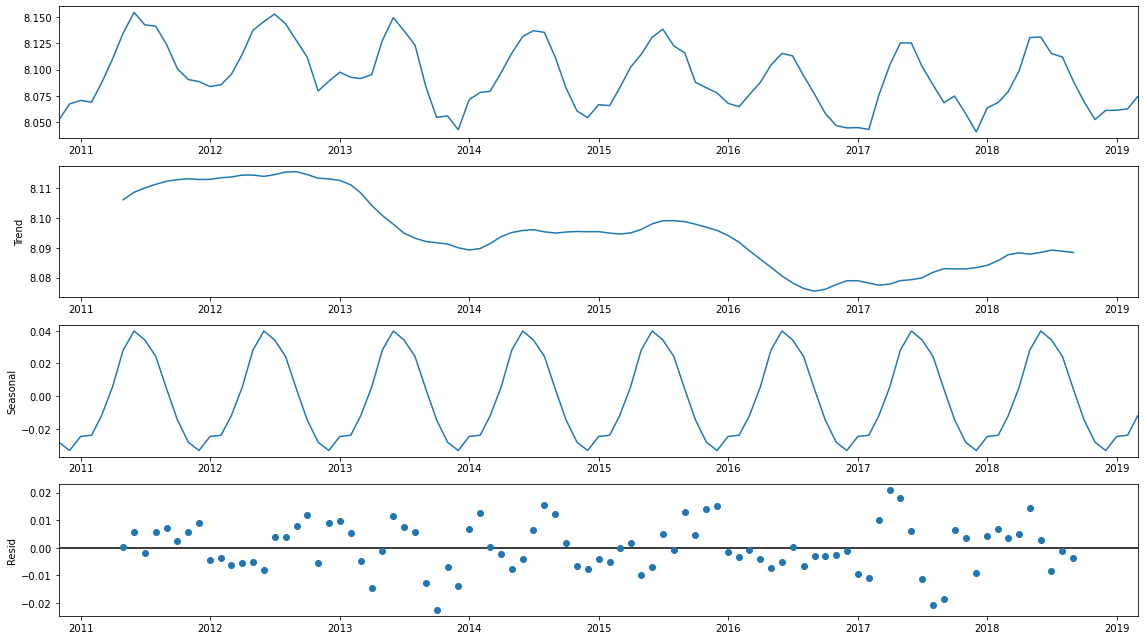

In [18]:
print('Summary of PH data')
print('This graphic shows the rolling avg, Trend, Seasonality and Residuals of the dataset')
decomposition = sm.tsa.seasonal_decompose(PHdata)
plt.rcParams["figure.figsize"] = [16,9]
decomposition.plot()

plt.show()

In [19]:
import itertools
#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(12,13)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline

warnings.filterwarnings("ignore") # specify to ignore warning messages
res = []
params = []
param_seasonals = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tempdata,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50)
#             print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            res.append(results.aic)
            params.append(param)
            param_seasonals.append(param_seasonal)
        except:
            continue
    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35273D-01    |proj g|=  5.48357D-01

At iterate    5    f=  5.61845D-01    |proj g|=  4.42606D-02

At iterate   10    f=  5.57296D-01    |proj g|=  1.11851D-02

At iterate   15    f=  5.56432D-01    |proj g|=  7.26909D-03

At iterate   20    f=  5.56312D-01    |proj g|=  4.42894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     39      1     0     0   9.005D-04   5.563D-01
  F =  0.55630458397525173     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61973D-01    |proj g|=  3.47576D-01

At iterate    5    f=  5.63420D-01    |proj g|=  7.18856D-02

At iterate   10    f=  5.58078D-01    |proj g|=  1.34096D-02

At iterate   15    f=  5.56493D-01    |proj g|=  3.66338D-03

At iterate   20    f=  5.56266D-01    |proj g|=  1.68655D-03

At iterate   25    f=  5.56228D-01    |proj g|=  3.48275D-03

At iterate   30    f=  5.56223D-01    |proj g|=  1.28560D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     58      1     0     0   2.990D-03   5.562D-01
  F =  0.55622234575149521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54102D-01    |proj g|=  4.62350D-01

At iterate    5    f=  5.84689D-01    |proj g|=  1.68179D-01

At iterate   10    f=  5.59710D-01    |proj g|=  1.83799D-02

At iterate   15    f=  5.56665D-01    |proj g|=  9.61499D-03

At iter

 This problem is unconstrained.



At iterate   25    f=  5.56240D-01    |proj g|=  3.08243D-03

At iterate   30    f=  5.56238D-01    |proj g|=  9.27324D-04

At iterate   35    f=  5.56238D-01    |proj g|=  4.85172D-04

At iterate   40    f=  5.56238D-01    |proj g|=  4.12987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     58      1     0     0   1.201D-04   5.562D-01
  F =  0.55623789796532574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.74840D-01    |proj g|=  5.39644D-02

At iterate   10    f=  5.55008D-01    |proj g|=  2.84579D-02

At iterate   15    f=  5.52854D-01    |proj g|=  1.24881D-02

At iterate   20    f=  5.52529D-01    |proj g|=  3.17570D-03

At iterate   25    f=  5.52128D-01    |proj g|=  1.82660D-03

At iterate   30    f=  5.52098D-01    |proj g|=  3.91842D-04

At iterate   35    f=  5.52094D-01    |proj g|=  3.92884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     54      1     0     0   3.929D-04   5.521D-01
  F =  0.55209356865816928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.92928D-01    |proj g|=  8.32517D-02

At iterate   10    f=  5.57407D-01    |proj g|=  1.92075D-02

At iterate   15    f=  5.54740D-01    |proj g|=  3.26956D-03

At iterate   20    f=  5.54459D-01    |proj g|=  3.90203D-03

At iterate   25    f=  5.54397D-01    |proj g|=  3.41542D-04

At iterate   30    f=  5.54390D-01    |proj g|=  3.26929D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     56      1     0     0   4.713D-05   5.544D-01
  F =  0.55438818865823014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86446D-01    |proj g|=  3.70781D-01

At iterate    5    f=  6.51005D-01    |proj g|=  2.87620D-01


 This problem is unconstrained.



At iterate   10    f=  5.57811D-01    |proj g|=  2.27749D-02

At iterate   15    f=  5.53563D-01    |proj g|=  5.48904D-03

At iterate   20    f=  5.52491D-01    |proj g|=  4.32163D-03

At iterate   25    f=  5.51371D-01    |proj g|=  2.26694D-02

At iterate   30    f=  5.51157D-01    |proj g|=  1.35223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     49      1     0     0   5.390D-04   5.511D-01
  F =  0.55114367947106646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45614D-01    |proj g|=  5.95335D-01

At iterate    5    f=  4.96241D-01    |proj g|=  2.31322D-01

At iterate   10    f=  4.85563D-01    |proj g|=  1.95465D-02

At iterate   15    f=  4.81441D-01    |proj g|=  5.52368D-03

At iterate   20    f=  4.80843D-01    |proj g|=  4.30438D-03

At iterate   25    f=  4.80781D-01    |proj g|=  8.25091D-04

At iterate   30    f=  4.80775D-01    |proj g|=  3.36309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  4.76514D-01    |proj g|=  8.53739D-03

At iterate   20    f=  4.76357D-01    |proj g|=  9.60812D-04

At iterate   25    f=  4.76342D-01    |proj g|=  1.96912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   1.152D-03   4.763D-01
  F =  0.47634113270497058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71366D-01    |proj g|=  4.72224D-01

At iterate    5    f=  4.88399D-01    |proj g|=  1.69693D-01

At iterate   10    f=  4.81262D-01    |proj g|=  1.65053D-02

At iterate   15    f=  4.77780D-01    |proj g|=  3.85701D-03

At iterate   20    f=  4.77450D-01    |proj g|=  4.87083D-03

At iterate   25    f=  4.77394D-01    |proj g|=  1.22719D-03

At iterate   30    f=  4.77387D-01    |proj g|=  2.78986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  4.82815D-01    |proj g|=  4.70232D-02

At iterate   10    f=  4.73530D-01    |proj g|=  2.59623D-02

At iterate   15    f=  4.72957D-01    |proj g|=  3.20146D-03

At iterate   20    f=  4.72507D-01    |proj g|=  6.06666D-03

At iterate   25    f=  4.72380D-01    |proj g|=  8.46724D-03

At iterate   30    f=  4.72364D-01    |proj g|=  5.61532D-03

At iterate   35    f=  4.72361D-01    |proj g|=  6.82637D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     57      1     0     0   6.826D-05   4.724D-01
  F =  0.47236057042338570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  4.73139D-01    |proj g|=  1.50406D-02

At iterate   15    f=  4.69643D-01    |proj g|=  9.36216D-03

At iterate   20    f=  4.68793D-01    |proj g|=  1.58809D-02

At iterate   25    f=  4.68337D-01    |proj g|=  6.78164D-03

At iterate   30    f=  4.68293D-01    |proj g|=  1.55652D-03

At iterate   35    f=  4.68292D-01    |proj g|=  5.45721D-05

At iterate   40    f=  4.68286D-01    |proj g|=  4.28217D-04
  ys=-8.645E-06  -gs= 7.094E-06 BFGS update SKIPPED

At iterate   45    f=  4.68284D-01    |proj g|=  3.05142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     80      1     1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.71362D-01    |proj g|=  3.61991D-01

At iterate   10    f=  4.84686D-01    |proj g|=  5.87957D-02

At iterate   15    f=  4.75195D-01    |proj g|=  6.83200D-02

At iterate   20    f=  4.73868D-01    |proj g|=  1.56168D-02

At iterate   25    f=  4.73153D-01    |proj g|=  3.18480D-03

At iterate   30    f=  4.72508D-01    |proj g|=  2.41948D-03

At iterate   35    f=  4.72350D-01    |proj g|=  2.30880D-03

At iterate   40    f=  4.72317D-01    |proj g|=  3.42748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     54      1     0     0   3.364D-04   4.723D-01
  F =  0.472317263074

 This problem is unconstrained.



At iterate   20    f=  4.96653D-01    |proj g|=  7.59291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   9.283D-04   4.966D-01
  F =  0.49664218434332136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41915D-01    |proj g|=  3.31128D-01


 This problem is unconstrained.



At iterate    5    f=  5.18486D-01    |proj g|=  5.87287D-02

At iterate   10    f=  4.95773D-01    |proj g|=  3.98468D-03

At iterate   15    f=  4.95528D-01    |proj g|=  4.16180D-03

At iterate   20    f=  4.95104D-01    |proj g|=  7.57869D-03

At iterate   25    f=  4.95036D-01    |proj g|=  1.60017D-03

At iterate   30    f=  4.95026D-01    |proj g|=  4.76692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     46      1     0     0   2.210D-04   4.950D-01
  F =  0.49502402963203918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  4.96213D-01    |proj g|=  2.77378D-03

At iterate   20    f=  4.95399D-01    |proj g|=  4.89390D-03

At iterate   25    f=  4.95294D-01    |proj g|=  3.61890D-03

At iterate   30    f=  4.95276D-01    |proj g|=  1.21979D-03

At iterate   35    f=  4.95274D-01    |proj g|=  4.91328D-04

At iterate   40    f=  4.95273D-01    |proj g|=  1.66281D-04

At iterate   45    f=  4.95272D-01    |proj g|=  2.19494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     70      1     0     0   2.177D-04   4.953D-01
  F =  0.49527229988253840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.40301D-01    |proj g|=  1.06498D-01

At iterate   10    f=  4.92368D-01    |proj g|=  2.06736D-02

At iterate   15    f=  4.90582D-01    |proj g|=  1.12146D-02

At iterate   20    f=  4.89914D-01    |proj g|=  8.42562D-03

At iterate   25    f=  4.89501D-01    |proj g|=  3.53882D-03

At iterate   30    f=  4.89398D-01    |proj g|=  3.15109D-03

At iterate   35    f=  4.89387D-01    |proj g|=  2.17855D-03

At iterate   40    f=  4.89385D-01    |proj g|=  5.93726D-05

At iterate   45    f=  4.89385D-01    |proj g|=  1.23601D-03

At iterate   50    f=  4.89385D-01    |proj g|=  2.03464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35767D-01    |proj g|=  5.08432D-01

At iterate    5    f=  5.44045D-01    |proj g|=  1.19483D-01

At iterate   10    f=  4.93938D-01    |proj g|=  1.49180D-02

At iterate   15    f=  4.93019D-01    |proj g|=  9.32854D-03

At iterate   20    f=  4.91951D-01    |proj g|=  4.68501D-03

At iterate   25    f=  4.91791D-01    |proj g|=  5.24979D-03

At iterate   30    f=  4.91757D-01    |proj g|=  3.11805D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.12578D-01    |proj g|=  3.58405D-01

At iterate   10    f=  5.03846D-01    |proj g|=  7.39001D-02

At iterate   15    f=  4.91883D-01    |proj g|=  5.75780D-02

At iterate   20    f=  4.91343D-01    |proj g|=  1.15466D-02

At iterate   25    f=  4.90253D-01    |proj g|=  7.47732D-03

At iterate   30    f=  4.89415D-01    |proj g|=  6.79435D-04

At iterate   35    f=  4.89343D-01    |proj g|=  5.06219D-03

At iterate   40    f=  4.89279D-01    |proj g|=  2.55183D-03

At iterate   45    f=  4.89261D-01    |proj g|=  2.94014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     67   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  4.80763D-01    |proj g|=  3.23966D-03

At iterate   25    f=  4.80746D-01    |proj g|=  5.57801D-04

At iterate   30    f=  4.80746D-01    |proj g|=  3.28145D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     43      1     0     0   7.461D-05   4.807D-01
  F =  0.48074611453837435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45107D-01    |proj g|=  2.81767D-01


 This problem is unconstrained.



At iterate    5    f=  4.88924D-01    |proj g|=  7.41716D-02

At iterate   10    f=  4.77633D-01    |proj g|=  6.78093D-03

At iterate   15    f=  4.76495D-01    |proj g|=  2.39651D-03

At iterate   20    f=  4.76396D-01    |proj g|=  4.45497D-03

At iterate   25    f=  4.76339D-01    |proj g|=  7.79216D-04

At iterate   30    f=  4.76336D-01    |proj g|=  1.07642D-03

At iterate   35    f=  4.76333D-01    |proj g|=  2.33377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     60      1     0     0   5.054D-03   4.763D-01
  F =  0.47633121263527828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  4.77753D-01    |proj g|=  1.99635D-02

At iterate   20    f=  4.77418D-01    |proj g|=  2.39596D-03

At iterate   25    f=  4.77411D-01    |proj g|=  1.10767D-03

At iterate   30    f=  4.77386D-01    |proj g|=  3.16666D-04

At iterate   35    f=  4.77380D-01    |proj g|=  2.00407D-03

At iterate   40    f=  4.77377D-01    |proj g|=  6.18035D-04
  ys=-4.957E-07  -gs= 7.323E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     68      1     1     0   2.606D-04   4.774D-01
  F =  0.47737735295160660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate   10    f=  4.74106D-01    |proj g|=  4.62146D-02

At iterate   15    f=  4.72856D-01    |proj g|=  8.12206D-03

At iterate   20    f=  4.72409D-01    |proj g|=  2.33660D-02

At iterate   25    f=  4.72254D-01    |proj g|=  5.45548D-03

At iterate   30    f=  4.72214D-01    |proj g|=  3.17635D-03

At iterate   35    f=  4.72184D-01    |proj g|=  8.92095D-04

At iterate   40    f=  4.72180D-01    |proj g|=  4.31714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     53      1     0     0   3.625D-04   4.722D-01
  F =  0.47218001106819185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.04644D-01    |proj g|=  6.43970D-02

At iterate   10    f=  4.72978D-01    |proj g|=  2.61347D-02

At iterate   15    f=  4.68966D-01    |proj g|=  1.25435D-02

At iterate   20    f=  4.68431D-01    |proj g|=  2.90959D-03

At iterate   25    f=  4.68369D-01    |proj g|=  9.09944D-03

At iterate   30    f=  4.68283D-01    |proj g|=  1.25247D-03

At iterate   35    f=  4.68275D-01    |proj g|=  1.33182D-03

At iterate   40    f=  4.68271D-01    |proj g|=  6.81358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     62      1     0     0   3.604D-04   4.683D-01
  F =  0.468270948804

 This problem is unconstrained.



At iterate    5    f=  5.72446D-01    |proj g|=  3.06774D-01

At iterate   10    f=  4.84477D-01    |proj g|=  5.19087D-02

At iterate   15    f=  4.75561D-01    |proj g|=  1.33451D-02

At iterate   20    f=  4.73984D-01    |proj g|=  5.46086D-03

At iterate   25    f=  4.73030D-01    |proj g|=  9.86454D-03

At iterate   30    f=  4.72389D-01    |proj g|=  2.48946D-02

At iterate   35    f=  4.72188D-01    |proj g|=  5.08548D-04

At iterate   40    f=  4.72158D-01    |proj g|=  3.26720D-03

At iterate   45    f=  4.72150D-01    |proj g|=  6.68635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     67   

 This problem is unconstrained.



At iterate   20    f=  4.84947D-01    |proj g|=  4.08954D-03

At iterate   25    f=  4.84902D-01    |proj g|=  2.79871D-03

At iterate   30    f=  4.84901D-01    |proj g|=  6.59470D-05

At iterate   35    f=  4.84899D-01    |proj g|=  6.37890D-04

At iterate   40    f=  4.84898D-01    |proj g|=  5.64104D-04

At iterate   45    f=  4.84897D-01    |proj g|=  7.99692D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     74      1     0     0   2.943D-04   4.849D-01
  F =  0.48489726318797072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  5.17382D-01    |proj g|=  1.47534D-01

At iterate   10    f=  4.82164D-01    |proj g|=  4.75175D-02

At iterate   15    f=  4.81831D-01    |proj g|=  8.19622D-04

At iterate   20    f=  4.81724D-01    |proj g|=  4.57622D-03

At iterate   25    f=  4.81632D-01    |proj g|=  1.09022D-03

At iterate   30    f=  4.81618D-01    |proj g|=  6.78312D-04

At iterate   35    f=  4.81617D-01    |proj g|=  5.51643D-04

At iterate   40    f=  4.81617D-01    |proj g|=  8.19811D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     54      1     0     0   9.328D-05   4.816D-01
  F =  0.481617191306

 This problem is unconstrained.



At iterate   20    f=  4.82605D-01    |proj g|=  1.05362D-02

At iterate   25    f=  4.82425D-01    |proj g|=  5.58006D-03

At iterate   30    f=  4.82404D-01    |proj g|=  5.24932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     44      1     0     0   5.730D-04   4.824D-01
  F =  0.48240154621419562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01243D-01    |proj g|=  3.68035D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  4.80119D-01    |proj g|=  9.60762D-02

At iterate   15    f=  4.77205D-01    |proj g|=  8.40030D-04

At iterate   20    f=  4.77073D-01    |proj g|=  1.28013D-02

At iterate   25    f=  4.76902D-01    |proj g|=  1.68256D-02

At iterate   30    f=  4.76683D-01    |proj g|=  4.42791D-04

At iterate   35    f=  4.76670D-01    |proj g|=  6.51806D-04

At iterate   40    f=  4.76667D-01    |proj g|=  5.98430D-04

At iterate   45    f=  4.76667D-01    |proj g|=  5.28933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     59      1     0     0   5.289D-05   4.767D-01
  F =  0.476666986796

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04647D-01    |proj g|=  4.94106D-01

At iterate    5    f=  5.47284D-01    |proj g|=  7.42760D-02

At iterate   10    f=  4.75208D-01    |proj g|=  3.53905D-02

At iterate   15    f=  4.73917D-01    |proj g|=  4.44129D-03

At iterate   20    f=  4.73768D-01    |proj g|=  1.58521D-02

At iterate   25    f=  4.73292D-01    |proj g|=  5.79544D-03

At iterate   30    f=  4.73210D-01    |proj g|=  3.09582D-03

At iterate   35    f=  4.73197D-01    |proj g|=  1.04667D-03

At iterate   40    f=  4.73195D-01    |proj g|=  2.57991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.48389D-01    |proj g|=  3.46835D-01

At iterate    5    f=  6.08571D-01    |proj g|=  1.93100D-01

At iterate   10    f=  4.91013D-01    |proj g|=  1.22356D-01

At iterate   15    f=  4.79397D-01    |proj g|=  1.35553D-02

At iterate   20    f=  4.78916D-01    |proj g|=  1.38602D-02

At iterate   25    f=  4.77598D-01    |proj g|=  4.09269D-03

At iterate   30    f=  4.77142D-01    |proj g|=  3.53137D-03

At iterate   35    f=  4.76747D-01    |proj g|=  3.05810D-03

At iterate   40    f=  4.76670D-01    |proj g|=  1.04044D-02

At iterate   45    f=  4.76665D-01    |proj g|=  1.94852D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   25    f=  4.78121D-01    |proj g|=  6.24370D-04

At iterate   30    f=  4.78107D-01    |proj g|=  1.54735D-03

At iterate   35    f=  4.78104D-01    |proj g|=  5.65537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     48      1     0     0   7.195D-04   4.781D-01
  F =  0.47810417891500062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45630D-01    |proj g|=  1.14968D+00

At iterate    5    f=  5.31298D-01    |proj g|=  1.13214D-01

At iterate   10    f=  4.78360D-01    |proj g|=  1.56458D-02

At iterate   15    f=  4.74617D-01    |proj g|=  7.04777D-03

At iterate   20    f=  4.74180D-01    |proj g|=  3.27786D-03

At iterate   25    f=  4.74110D-01    |proj g|=  2.16426D-03

At iterate   30    f=  4.73999D-01    |proj g|=  5.83289D-04

At iterate   35    f=  4.73992D-01    |proj g|=  2.26935D-04

At iterate   40    f=  4.73989D-01    |proj g|=  7.77039D-04

At iterate   45    f=  4.73987D-01    |proj g|=  1.13422D-03

At iterate   50    f=  4.73987D-01    |proj g|=  7.02630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44380D-01    |proj g|=  4.33862D-01

At iterate    5    f=  5.27571D-01    |proj g|=  8.61688D-02

At iterate   10    f=  4.82084D-01    |proj g|=  1.77713D-02

At iterate   15    f=  4.75845D-01    |proj g|=  1.77579D-02

At iterate   20    f=  4.75060D-01    |proj g|=  1.27027D-02

At iterate   25    f=  4.74927D-01    |proj g|=  9.83768D-04

At iterate   30    f=  4.74871D-01    |proj g|=  4.33821D-03

At iterate   35    f=  4.74861D-01    |proj g|=  3.91804D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  4.99791D-01    |proj g|=  1.14501D-01

At iterate   10    f=  4.72861D-01    |proj g|=  7.21005D-03

At iterate   15    f=  4.70397D-01    |proj g|=  4.07298D-03

At iterate   20    f=  4.69581D-01    |proj g|=  2.90790D-03

At iterate   25    f=  4.69307D-01    |proj g|=  8.31245D-03

At iterate   30    f=  4.69262D-01    |proj g|=  9.58436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     43      1     0     0   9.286D-04   4.693D-01
  F =  0.46926249940760978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36657D-01    |proj g|=  4.41172D-01

At iterate    5    f=  5.25576D-01    |proj g|=  8.31307D-02

At iterate   10    f=  4.78043D-01    |proj g|=  2.19882D-02

At iterate   15    f=  4.68766D-01    |proj g|=  5.05856D-02

At iterate   20    f=  4.67714D-01    |proj g|=  1.15724D-02

At iterate   25    f=  4.67435D-01    |proj g|=  2.02473D-03

At iterate   30    f=  4.67253D-01    |proj g|=  5.84443D-03

At iterate   35    f=  4.67214D-01    |proj g|=  4.07402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  4.88722D-01    |proj g|=  3.56969D-02

At iterate   15    f=  4.74937D-01    |proj g|=  1.25285D-02

At iterate   20    f=  4.71752D-01    |proj g|=  5.59356D-02

At iterate   25    f=  4.70586D-01    |proj g|=  1.09594D-02

At iterate   30    f=  4.69545D-01    |proj g|=  1.85947D-02

At iterate   35    f=  4.69277D-01    |proj g|=  4.96211D-03

At iterate   40    f=  4.69239D-01    |proj g|=  1.43609D-03

At iterate   45    f=  4.69239D-01    |proj g|=  4.70813D-04

At iterate   50    f=  4.69237D-01    |proj g|=  9.08507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62   

In [20]:
res = np.array(res)
k = res.argmin()
print('Minimum AIC',res.argmin())
print('ARIMA{}x{}12 - AIC:{}'.format(params[k], param_seasonals[k], res[k]))

Minimum AIC 6
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:105.11649203281783


In [21]:
temp_mod = sm.tsa.statespace.SARIMAX(tempdata,
                                order=params[k],
                                seasonal_order=param_seasonals[k], 
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = temp_mod.fit()

print(results.summary().tables[1])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32717D-01    |proj g|=  4.97467D-01

At iterate    5    f=  3.78225D-01    |proj g|=  7.06656D-02

At iterate   10    f=  3.71186D-01    |proj g|=  1.06579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   4.669D-05   3.712D-01
  F =  0.37118511803743681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025    

 This problem is unconstrained.


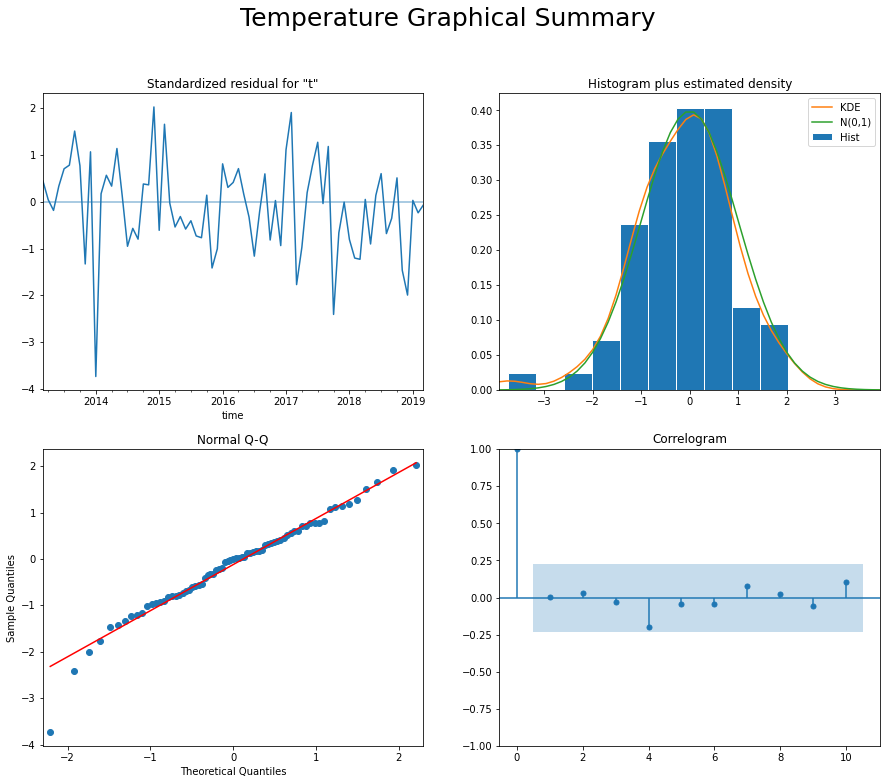

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.suptitle("Temperature Graphical Summary", fontsize=25)
plt.show()


In [26]:
pred_temp = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred_temp.conf_int()


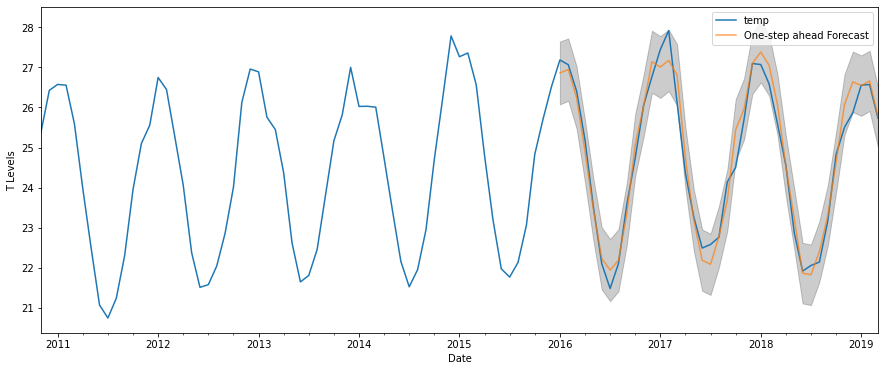

In [27]:
ax = tempdata.plot(label='observed',figsize=(15, 6))
pred_temp.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('T Levels')
plt.legend()

plt.show()


In [28]:
temp_forecasted = pred_temp.predicted_mean.values
temp_truth = tempdata['2016-01-01':].values

# Compute the mean square error
mse = ((temp_forecasted - temp_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))


The Mean Squared Error of our forecasts is 7.127355


In [22]:
pred_dynamic_temp = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic_temp.conf_int()


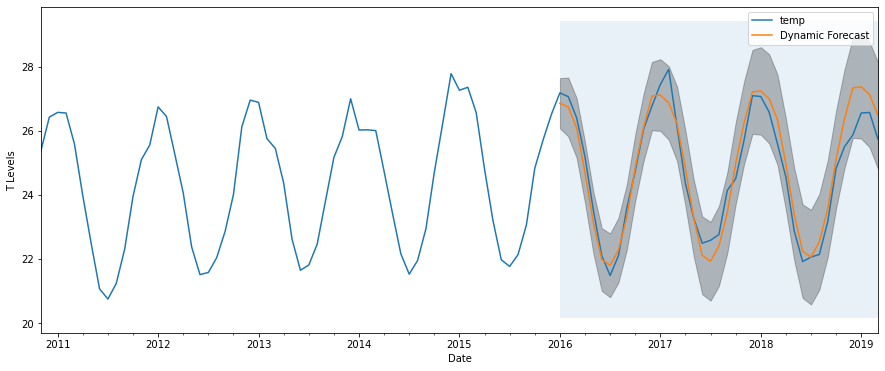

In [30]:
ax = tempdata.plot(label='observed', figsize=(15, 6))
pred_dynamic_temp.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), tempdata.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('T Levels')

plt.legend()
plt.show()


In [31]:
# Extract the predicted and true values of our time series
temp_forecasted = pred_dynamic_temp.predicted_mean
temp_truth = tempdata.temp

# Compute the mean square error
mse = ((temp_forecasted - temp_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))


The Mean Squared Error of our forecasts is 0.265124


In [23]:
# Get forecast 500 steps ahead in future
pred_temp = results.get_forecast(steps=505)

# Get confidence intervals of forecasts
pred_ci = pred_temp.conf_int()


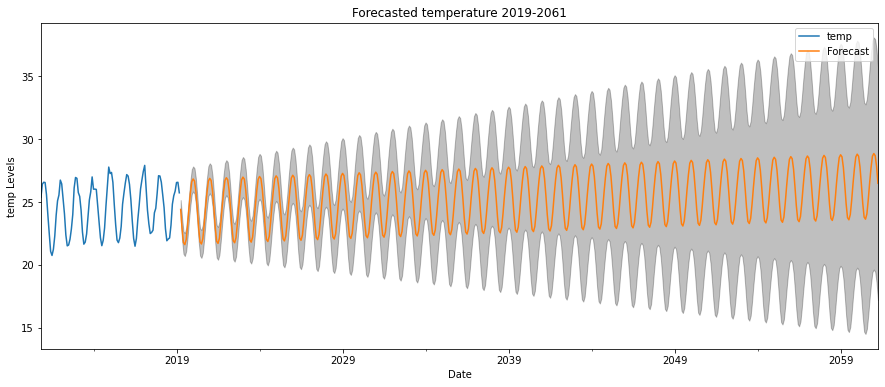

In [24]:
ax = tempdata.plot(label='observed', figsize=(15, 6))
pred_temp.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Forecasted temperature 2019-2061')
ax.set_xlabel('Date')
ax.set_ylabel('temp Levels')

plt.legend()
plt.show()


# 4. Compiling data in to one dataset

In [25]:
data = {'time': pred_PH.predicted_mean.index,
        'temp': pred_temp.predicted_mean.values,
        'PH': pred_PH.predicted_mean.values}
df = pd.DataFrame(data, columns=['time','temp', 'PH'])
df = df.set_index('time', drop=True)

In [26]:
df 

,temp,PH
time,,
2019-04-01,24.409995,8.090416
2019-05-01,22.888009,8.114162
2019-06-01,21.775684,8.125841
2019-07-01,21.610153,8.120293
2019-08-01,22.020777,8.110165
...,...,...
2060-12-01,28.642024,7.986459
2061-01-01,28.862799,7.993381
2061-02-01,28.699733,7.993695


In [48]:
def param_predict(dataset, fname):
    
    '''
    This function utlises historical data to construct and ARIMA predictive 
    model of PH and Temperature from 2019 to 2061.
    
    args:
    
    - dataset: netCDF data file with historical pH and temperature data.
    - fname: name of file to be saved 
    '''
    #packages for model
    import warnings
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import netCDF4
    import xarray as xr
    
    
    from matplotlib import pyplot as plt
    plt.rcParams['figure.figsize'] = (12,7)
    
    ds = xr.open_dataset(dataset)
    ds = ds.to_dataframe()
   
    # PH
    
    PHdata = ds[['PH']].resample('MS').mean()
    
    # Temp
    
    tempdata = ds[['temp']].resample('MS').mean()
    
    print('Summary of PH data')
    print('This graphic shows the rolling avg, Trend, Seasonality and Residuals of the dataset')
    decomposition = sm.tsa.seasonal_decompose(PHdata)
    plt.rcParams["figure.figsize"] = [16,9]
    decomposition.plot()

    plt.show()
    
    from statsmodels.tsa.stattools import adfuller
    def check_stationarity(timeseries):
        result = adfuller(timeseries,autolag='AIC')
        dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        print('The test statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        return result[1]

    pvalue = check_stationarity(PHdata)
    
    import itertools
    #set parameter range
    p = range(0,3)
    q = range(0,3)
    d = range(0,2)
    s = range(12,13)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    # SARIMA model pipeline

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    res = []
    params = []
    param_seasonals = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(PHdata,
                                        order=param,
                                        seasonal_order=param_seasonal)
                results = mod.fit(max_iter = 25)
                res.append(results.aic)
                params.append(param)
                param_seasonals.append(param_seasonal)
            except:
                continue
    
    res = np.array(res)
    k = res.argmin()
    print('Minimum AIC',res.argmin())
    print('ARIMA{}x{}12 - AIC:{}'.format(params[k], param_seasonals[k], res[k]))
    
    PH_mod = sm.tsa.statespace.SARIMAX(PHdata,
                                    order= params[k],
                                    seasonal_order= param_seasonals[k],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = PH_mod.fit()

    print(results.summary().tables[1])

    print('PH Graphical diagnostic')
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()

    pred_dynamic_PH = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic_PH.conf_int()

    # Extract the predicted and true values of our time series
    PH_forecasted = pred_dynamic_PH.predicted_mean
    PH_truth = PHdata.PH

    # Compute the mean square error
    mse = ((PH_forecasted - PH_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))

    # Get forecast 502 steps ahead in future
    pred_PH = results.get_forecast(steps=502)

    # Get confidence intervals of forecasts
    pred_ci = pred_PH.conf_int()
    
    # Plot the forecast
    ax = PHdata.plot(label='observed', figsize=(15, 6))
    pred_PH.predicted_mean.plot(ax=ax, label='Forecast')
#     ax.fill_between(pred_ci.index,
#                     pred_ci.iloc[:, 0],
#                     pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_title('Forecast of pH 2019-2061')
    ax.set_xlabel('Date')
    ax.set_ylabel('PH Levels')

    plt.legend()
    plt.show()
    
    print('Repeating the process for temperature')
    tempdata = ds
    tempdata= tempdata[['temp']].resample('MS').mean()
    
    print('Summary of PH data')
    print('This graphic shows the rolling avg, Trend, Seasonality and Residuals of the dataset')
    decomposition = sm.tsa.seasonal_decompose(PHdata)
    plt.rcParams["figure.figsize"] = [16,9]
    decomposition.plot()

    plt.show()
    
    pvalue = check_stationarity(tempdata)
    
    import itertools
    #set parameter range
    p = range(0,3)
    q = range(0,3)
    d = range(0,2)
    s = range(12,13)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    # SARIMA model pipeline

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    res = []
    params = []
    param_seasonals = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(tempdata,
                                        order=param,
                                        seasonal_order=param_seasonal)
                results = mod.fit(max_iter = 25)
                res.append(results.aic)
                params.append(param)
                param_seasonals.append(param_seasonal)
            except:
                continue
    
    res = np.array(res)
    k = res.argmin()
    print('Minimum AIC',res.argmin())
    print('ARIMA{}x{}12 - AIC:{}'.format(params[k], param_seasonals[k], res[k]))
    
    temp_mod = sm.tsa.statespace.SARIMAX(tempdata,
                                    order= params[k],
                                    seasonal_order= param_seasonals[k],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)


    
    results = temp_mod.fit()

    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(15, 12))
    plt.suptitle("Temperature Graphical Summary", fontsize=25)
    plt.show()
    
    pred_dynamic_temp = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic_temp.conf_int()

    # Extract the predicted and true values of our time series
    temp_forecasted = pred_dynamic_temp.predicted_mean
    temp_truth = tempdata.temp

    # Compute the mean square error
    mse = ((temp_forecasted - temp_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))

    # Get forecast 502 steps ahead in future
    pred_temp = results.get_forecast(steps=502)

    # Get confidence intervals of forecasts
    pred_ci = pred_temp.conf_int()

    ax = tempdata.plot(label='observed', figsize=(15, 6))
    pred_temp.predicted_mean.plot(ax=ax, label='Forecast')
    ax.set_title('Forecasted temperature 2019-2061')
    ax.set_xlabel('Date')
    ax.set_ylabel('temp Levels')

    plt.legend()
    plt.show()

    # Combine both the datasets for export
    data = {'time': pred_temp.predicted_mean.index,
        'temp': pred_temp.predicted_mean.values,
        'ph': pred_PH.predicted_mean.values}
    
    # Now we combine all the data
    df = pd.DataFrame(data, columns=['time','temp', 'ph'])
    df = df.set_index('time', drop=True)
    

    # Save Data
    xr.Dataset(df.to_xarray()).to_netcdf(f"test/{fname}_forecast.nc")
    
    return df
    

In [ ]:
dataset = 'historical_data/Yule.nc'

param_predict(dataset, fname)

# 5. Visualising the data we have collected and created


## 5.1 Historical data

In [6]:
yule = xr.open_dataset('Reef-Data/Yule_reef.nc')
yule= yule.to_dataframe()
unnamed = xr.open_dataset('Reef-Data/UnNamed_reef.nc')
unnamed= unnamed.to_dataframe()
davies = xr.open_dataset('Reef-Data/Davies_reef.nc')
davies= davies.to_dataframe()
feather = xr.open_dataset('Reef-Data/Feather_reef.nc')
feather= feather.to_dataframe()
hardy = xr.open_dataset('Reef-Data/Hardy_reef.nc')
hardy= hardy.to_dataframe()
heron = xr.open_dataset('Reef-Data/Heron_reef.nc')
heron= heron.to_dataframe()
key = xr.open_dataset('Reef-Data/Key_reef.nc')
key= key.to_dataframe()
lizard = xr.open_dataset('Reef-Data/Lizard_island_reef.nc')
lizard= lizard.to_dataframe()
pike = xr.open_dataset('Reef-Data/Pike_reef.nc')
pike= pike.to_dataframe()


In [7]:
combined = pd.concat([yule.assign(dataset='yule'), unnamed.assign(dataset='unnamed'),
                      davies.assign(dataset='davies'),feather.assign(dataset='feather'),
                     hardy.assign(dataset='hardy'),heron.assign(dataset='heron'),key.assign(dataset='key'),
                     lizard.assign(dataset='lizard'), pike.assign(dataset='pike')])


combined = combined.reset_index()


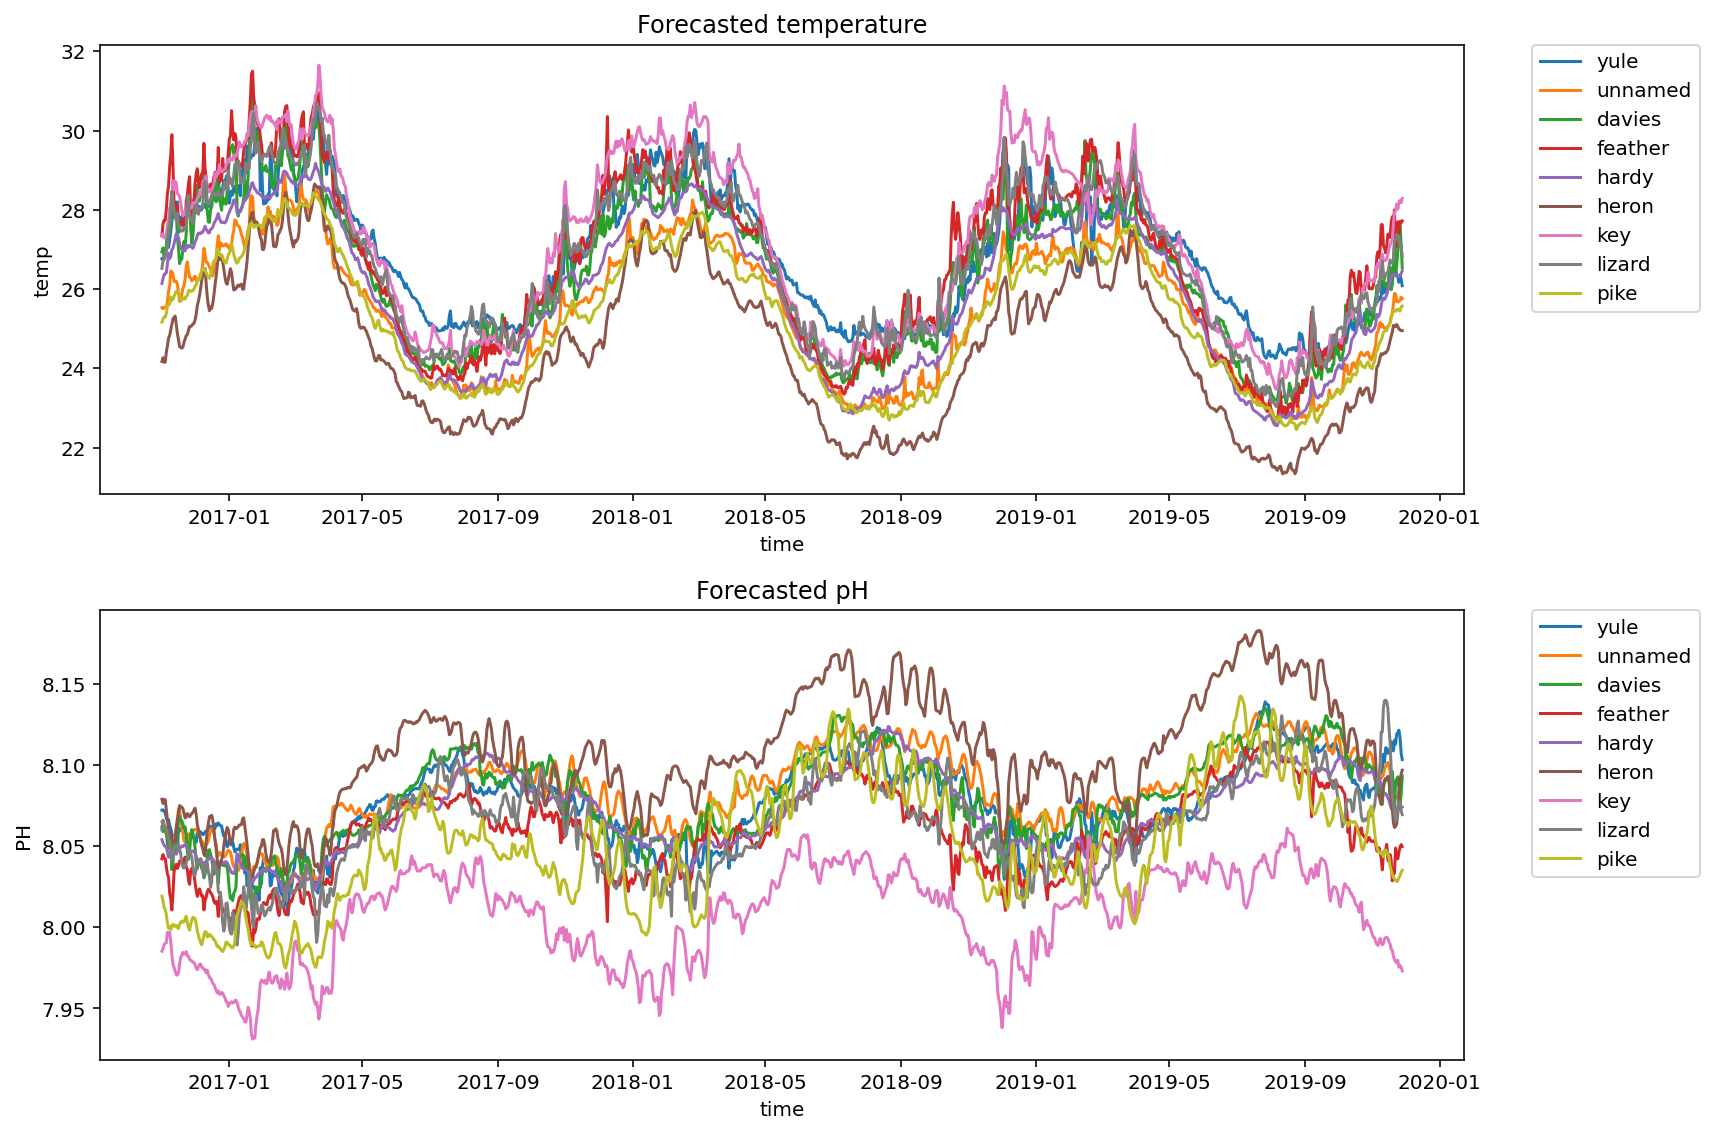

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.lineplot(x='time', y='temp', data=combined,
                hue='dataset', ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Forecasted temperature')
# plt.show()

plt.subplot(2, 1, 2)
sns.lineplot(x='time', y='PH', data=combined,
                hue='dataset', ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Forecasted pH')

# plt.show()

plt.tight_layout()
plt.savefig('reef-param.png', dpi=200)


## 5.2 Forecasted data

In [10]:
yule = xr.open_dataset('future_data/yule_forecast.nc')
yule= yule.to_dataframe()
unnamed = xr.open_dataset('future_data/UnNamed_forecast.nc')
unnamed= unnamed.to_dataframe()
davies = xr.open_dataset('future_data/davies_forecast.nc')
davies= davies.to_dataframe()
feather = xr.open_dataset('future_data/feather_forecast.nc')
feather= feather.to_dataframe()
hardy = xr.open_dataset('future_data/hardy_forecast.nc')
hardy= hardy.to_dataframe()
heron = xr.open_dataset('future_data/heron_forecast.nc')
heron= heron.to_dataframe()
key = xr.open_dataset('future_data/key_forecast.nc')
key= key.to_dataframe()
lizard = xr.open_dataset('future_data/lizard_forecast.nc')
lizard= lizard.to_dataframe()
pike = xr.open_dataset('future_data/pike_forecast.nc')
pike= pike.to_dataframe()

In [11]:
combined = pd.concat([yule.assign(dataset='yule'), unnamed.assign(dataset='unnamed'),
                      davies.assign(dataset='davies'),feather.assign(dataset='feather'),
                     hardy.assign(dataset='hardy'),heron.assign(dataset='heron'),key.assign(dataset='key'),
                     lizard.assign(dataset='lizard'), pike.assign(dataset='pike')])


combined = combined.reset_index()

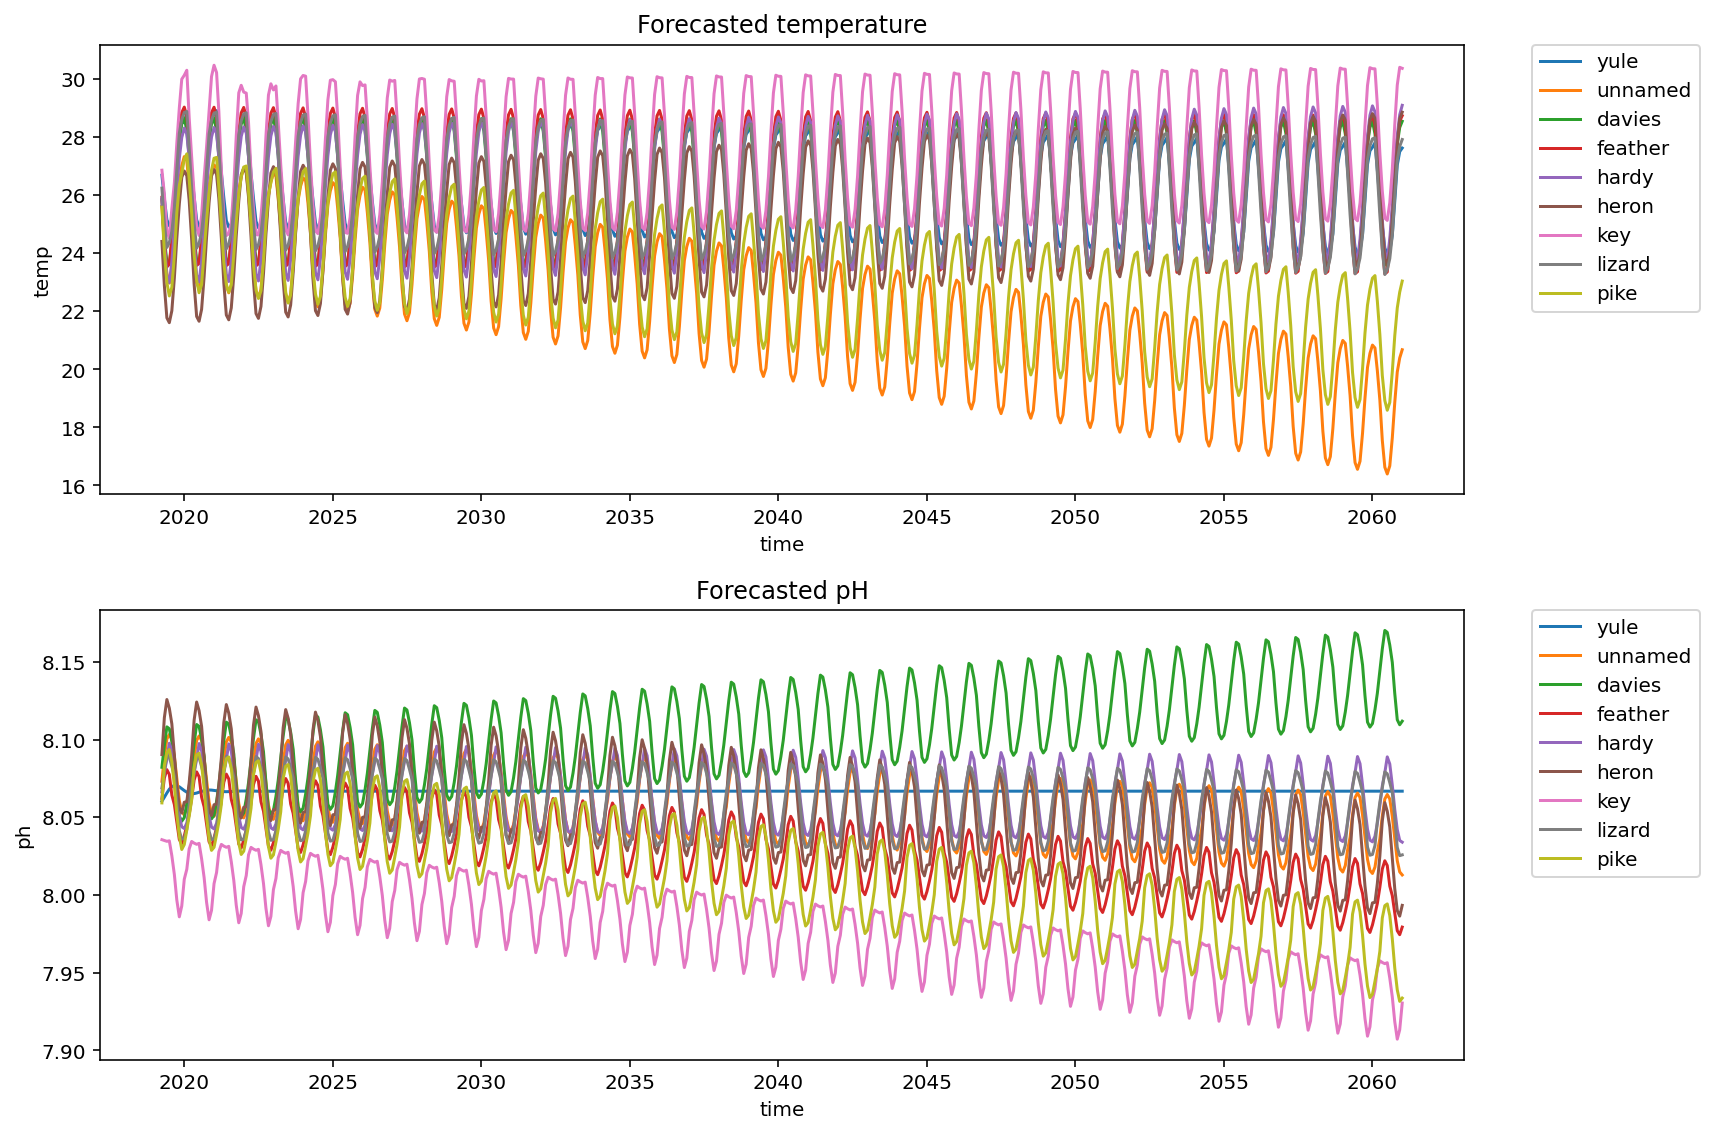

In [13]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.lineplot(x='time', y='temp', data=combined,
                hue='dataset', ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Forecasted temperature')
# plt.show()

plt.subplot(2, 1, 2)
sns.lineplot(x='time', y='ph', data=combined,
                hue='dataset', ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Forecasted pH')

# plt.show()

plt.tight_layout()
plt.savefig('forecasted-param.png', dpi=200)
